In [ ]:
# analysis of zonal mena O-A for single-cycle varBC experiment
# initial built: 2024/07/17

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy
print(cartopy.__version__)

0.21.1


In [2]:
root_dir = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/single_cycle_VarBC_experiment/cnvstats/'
obs_var = 't'
obs_var_long_name = 'Temperature'
exps = ['bc0_inf','bc0_noinf','bc1_inf','bc1_noinf']

In [3]:
lat={}; lon={}; pres={};
qc={}; ause={}; omfadj={};

for exp in exps:
    fn = f'{root_dir}/{exp}/diag_conv_{obs_var}_ges.2022070100.nc4'
    fnc = nc.Dataset(fn)
    qc[exp]     = fnc.variables['Prep_QC_Mark'][:]       
    lon[exp]    = fnc.variables['Longitude'][:]
    lat[exp]    = fnc.variables['Latitude'][:]
    pres[exp]   = fnc.variables['Pressure'][:]   
    ause[exp]   = fnc.variables['Analysis_Use_Flag'][:]
    omfadj[exp] = fnc.variables['Obs_Minus_Forecast_adjusted'][:]

In [4]:
# select data
select  = (qc['bc0_inf'] <= 4) 

lons={}; lats={}; ps={}; omfs={};
for exp in exps:
    lons[exp] = lon[exp][select]
    lats[exp] = lat[exp][select]
    ps[exp]   = pres[exp][select]
    omfs[exp] = omfadj[exp][select]

In [5]:
# vertical and horizontal grid definitions
dlat=6
latu=np.arange(-90+dlat, 90+dlat, dlat) # u = up   = north
latd=np.arange(-90,90,dlat)             # d = down = south

if obs_var in ('q','t'):
    #ptop=np.array([1000., 900.,800.,600.,400.,300.,250.,200.,150.,100., 50.,30.,20.,10., 5.,0.])
    #pbot=np.array([1200.,1000.,900.,800.,600.,400.,300.,250.,200.,150.,100.,50.,30.,20.,10.,5.])
    ptop=np.array([1000., 900.,800.,700.,600.,500.,400.,300.,200.,150.,100., 50.,30.,20.,10., 5.,0.])
    pbot=np.array([1200.,1000.,900.,800.,700.,600.,500.,400.,300.,200.,150.,100.,50.,30.,20.,10.,5.])
    #ptop=np.array([1000., 950.,900.,850.,800.,750.,700.,650.,600.,500.,400.,300.,200.,150.,100., 50.,30.,20.,10., 5.,0.])
    #pbot=np.array([1200.,1000.,950.,900.,850.,800.,750.,700.,650.,600.,500.,400.,300.,200.,150.,100.,50.,30.,20.,10.,5.])
#elif obs_var == 'q':
#    ptop=np.array([1000., 950.,900.,850.,800.,700.,600.,500.,400.,300.,200.,100.])
#    pbot=np.array([1200.,1000.,950.,900.,850.,800.,700.,600.,500.,400.,300.,200.])    
elif obs_var == 'gps':
    ptop=np.array([1000., 900.,800.,600.,400.,300.,250.,200.,150.,100., 50.,30.,20.,10., 7.,5.,3.,2.,1.,0.])
    pbot=np.array([1200.,1000.,900.,800.,600.,400.,300.,250.,200.,150.,100.,50.,30.,20.,10.,7.,5.,3.,2.,1.])

g_center_lev = 0.5*(ptop+pbot)
g_center_lev[0] = 1010

g_center_lat = 0.5*(latu+latd)
glev, glat = np.meshgrid(g_center_lev, g_center_lat)

omaavg = np.zeros(glev.shape)
omastd = np.zeros(glev.shape)
count  = np.zeros(glev.shape) 

In [6]:
# zonal mean:

exptest = 'bc1_inf'
expref  = 'bc0_inf'

for i, zz in enumerate(ptop):
    for j, yy in enumerate(latu):
        lat_tmp = lats[exptest]
        lev_tmp = ps[exptest]
        omf_tmp = omfs[expref] 
        #omf_tmp = omfs[expref] - omfs[exptest]      
        select_obs = (lat_tmp >= latd[j]) & (lat_tmp < latu[j]) & (lev_tmp <= pbot[i]) & (lev_tmp > ptop[i]) 
        
        count[j,i]  = len(select_obs)
        omaavg[j,i] = np.mean(omf_tmp[select_obs])
        omastd[j,i] = np.std(omf_tmp[select_obs])

/home/Chih-Chi.Hu/.local/lib/python3.8/site-packages/numpy/ma/core.py:5317: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/home/Chih-Chi.Hu/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/Chih-Chi.Hu/.local/lib/python3.8/site-packages/numpy/ma/core.py:5400: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/Chih-Chi.Hu/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/Chih-Chi.Hu/.local/lib/python3.8/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_33990/2863040913.py:16: UserWarning: Warning: converting a masked element to nan.
  omastd[j,i] = np.std(omf_tmp[select

"\nif pltvars == 'T':\n    cbar.set_label('$\\Delta T(K)$', fontsize=14)\nelif pltvars == 'HUM':\n    cbar.set_label('$\\Delta q (g/kg)$', fontsize=14)\n"

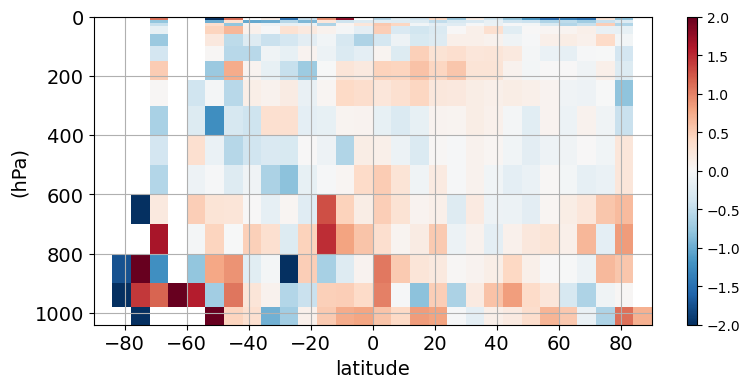

In [7]:
v_min = -2
v_max =  2


fig, ax = plt.subplots(figsize=(9,4))
#contour1=ax.contourf(lats, levs, plt_cont_var, cmap='RdBu_r', levels=plt_levs)
contour1=ax.pcolormesh(glat, glev, omaavg, cmap='RdBu_r', vmin=v_min, vmax=v_max)

ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel('latitude',fontsize=14)
ax.set_ylabel('(hPa)',fontsize=14)
ax.tick_params(axis='x', labelsize=14)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=14)  # Set the size to 14 points
ax.grid(True)
#ax.set_title(f'{pltvars} increment ({exptest} - {expref})',fontsize=15)
#ax.set_title(f'{pltvars} increment ({expref})',fontsize=15)

cbar = fig.colorbar(contour1,location='right',aspect=30)

'''
if pltvars == 'T':
    cbar.set_label('$\Delta T(K)$', fontsize=14)
elif pltvars == 'HUM':
    cbar.set_label('$\Delta q (g/kg)$', fontsize=14)
'''
#plt.savefig(f'{pltvars}_inc_{exptest}_minus_{expref}.png', dpi=200, bbox_inches='tight')

In [ ]:

expid1='CTRL' 
expid2='CTRL_no_situ'
savefig = True

#for i in range(1):
for i in range(len(meshinfo['levs'])):
    tmp1 = meshinfo['mesh'][expid1][i]
    tmp1[np.where(tmp1== -99999.)] = np.nan

    tmp2 = meshinfo['mesh'][expid2][i]
    tmp2[np.where(tmp2== -99999.)] = np.nan

    # Plot 1 -- the mean OmF for exp1 
    tmp = tmp1
    q25 = np.nanquantile(tmp, 0.25)
    q75 = np.nanquantile(tmp, 0.75)
    pltrange = 6*0.5*( np.abs(q25) + np.abs(q75)) 
    
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

    ax.coastlines()
    if obs_var == 'q':
        contour = ax.pcolormesh(meshinfo['lon'], meshinfo['lat'], tmp, cmap='BrBG_r', vmin=-pltrange, vmax=pltrange)
    else:
        contour = ax.pcolormesh(meshinfo['lon'], meshinfo['lat'], tmp, cmap='RdBu', vmin=-pltrange, vmax=pltrange)

    cbar = plt.colorbar(contour, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    if i==0:
        lev_bot = 1000
        lev_top = 1000
        ax.set_title(f'{obs_var_long_name} mean (OBS-{expid1}) [>= 1000 hPa] ',fontsize=14)
    else:
        if obs_var == 't':
            lev_bot = pbot[i]
            lev_top = ptop[i]
        elif obs_var == 'q':
            lev_bot = pbotq[i]
            lev_top = ptopq[i]
        elif obs_var == 'gps':
            lev_bot = pbotgps[i]
            lev_top = ptopgps[i]
            
        ax.set_title(f'{obs_var_long_name} mean (OBS-{expid1}) [{lev_bot:.0f} - {lev_top:.0f} hPa] ',fontsize=14)

    if savefig:
        plt.savefig(f'cnv_{obs_var}_mesh_omb_{expid1}_{lev_bot}-{lev_top}.png', dpi=200, bbox_inches='tight')



    # Plot 2 -- the mean OmF(exp1) - OmF(exp2) = exp2 - exp1 
    
    tmp = tmp1-tmp2
    q25 = np.nanquantile(tmp, 0.25)
    q75 = np.nanquantile(tmp, 0.75)
    pltrange = 6*0.5*( np.abs(q25) + np.abs(q75)) 
    
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

    ax.coastlines()
    if obs_var == 'q':
        contour = ax.pcolormesh(meshinfo['lon'], meshinfo['lat'], tmp, cmap='BrBG', vmin=-pltrange, vmax=pltrange)
    else:
        contour = ax.pcolormesh(meshinfo['lon'], meshinfo['lat'], tmp, cmap='RdBu_r', vmin=-pltrange, vmax=pltrange)
        
    cbar = plt.colorbar(contour, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    if i==0:
        lev_bot = 1000
        lev_top = 1000
        ax.set_title(f'{obs_var_long_name} mean ({expid2}-{expid1}) [>= 1000 hPa] ',fontsize=14)
    else:
        if obs_var == 't':
            lev_bot = pbot[i]
            lev_top = ptop[i]
        elif obs_var == 'q':
            lev_bot = pbotq[i]
            lev_top = ptopq[i]
        elif obs_var == 'gps':
            lev_bot = pbotgps[i]
            lev_top = ptopgps[i]
        ax.set_title(f'{obs_var_long_name} mean ({expid2}-{expid1}) [{lev_bot:.0f} - {lev_top:.0f} hPa] ',fontsize=14)
        
    if savefig:
        plt.savefig(f'cnv_{obs_var}_{expid2}_minus_{expid1}_{lev_bot}-{lev_top}.png', dpi=200, bbox_inches='tight')     

    # Plot 3 -- improve-or-not plot 
    
    test = (tmp1-tmp2)*tmp1
    tmp  = test/np.abs(test)
    q25 = np.nanquantile(tmp, 0.25)
    q75 = np.nanquantile(tmp, 0.75)
    pltrange = 1.2 
    
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

    ax.coastlines()
    contour = ax.pcolormesh(meshinfo['lon'], meshinfo['lat'], tmp, cmap='RdBu_r', vmin=-pltrange, vmax=pltrange)
        
    cbar = plt.colorbar(contour, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    if i==0:
        lev_bot = 1000
        lev_top = 1000
        ax.set_title(f'{obs_var_long_name} sign({expid2}-{expid1}, OBS-{expid1}) [>= 1000 hPa] ',fontsize=14)
    else:
        if obs_var == 't':
            lev_bot = pbot[i]
            lev_top = ptop[i]
        elif obs_var == 'q':
            lev_bot = pbotq[i]
            lev_top = ptopq[i]
        elif obs_var == 'gps':
            lev_bot = pbotgps[i]
            lev_top = ptopgps[i]
            
        ax.set_title(f'{obs_var_long_name} sign({expid2}-{expid1}, OBS-{expid1}) [{lev_bot:.0f} - {lev_top:.0f} hPa] ',fontsize=14)
        
    if savefig:
        plt.savefig(f'cnv_{obs_var}_if_{expid2}_better_than_{expid1}_{lev_bot}-{lev_top}.png', dpi=200, bbox_inches='tight')  

In [ ]:
meshinfo['levs']